# Extraktion aus unstrukturierten Daten

## Laden von Bibliotheken

In [1]:
import os
import api_keys

os.environ["OPENAI_API_KEY"] = api_keys.openai

In [4]:
!pip show langchain

Name: langchain
Version: 0.0.206
Summary: Building applications with LLMs through composability
Home-page: https://www.github.com/hwchase17/langchain
Author: 
Author-email: 
License: MIT
Location: c:\users\johan\anaconda3\envs\text_mining\lib\site-packages
Requires: aiohttp, async-timeout, dataclasses-json, langchainplus-sdk, numexpr, numpy, openapi-schema-pydantic, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

tqdm.pandas()

In [14]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import create_tagging_chain, create_tagging_chain_pydantic
from langchain.prompts import ChatPromptTemplate

## Textdaten laden

In [6]:
df = pd.read_parquet("data/raw/2023-07-10_gesamtedaten_rhein_neckar2.parquet")

In [24]:
len(df)

68663

Notiz: Nur Dokumente mit weniger als 3000 Token, da ansonsten ein anderes LLM genutzt werden muss

## Classification / Tagging


from langchain.chat_models import ChatOpenAI
from langchain.chains import create_tagging_chain, create_tagging_chain_pydantic
from langchain.prompts import ChatPromptTemplate

### Stichprobengröße bestimmen

In [19]:
import scipy.stats as st
from math import ceil

def sample(N, cl, e, p):
    # first we get the z-score
    z = st.norm.ppf(1 - (1 - cl) / 2)
    # then the n_0 value
    n_0 = z**2 * p * (1 - p) / e**2
    # and finally we calculate n
    n = n_0 / (1 + (n_0 - 1) / N)
    # we also need to round up to the nearest integer
    n = ceil(n)
    # finally we return our sample size
    return n

sample(len(df), 0.95, 0.05, 0.5)

382

### Stichprobe auswählen

In [20]:
df_3500 = df[df['token_laenge'] < 3500]
df_3500 = df_3500[df_3500['doc_typ'].notna()]

In [21]:
df_3500['doc_typ'].value_counts()

doc_typ
Vorlage             23797
Anhang Vorlage      18050
Beschluss            4512
Niederschrift        3001
Bekanntmachung       1559
Anhang Sitzung       1333
Anfrage               960
Antrag                774
Anhang Beschluss      639
Name: count, dtype: int64

* Dokumententypen gewichten, da Anhänge weniger interessant sind und mehr Anfragen und Anträge in der Stichprobe sind.

In [22]:
weights = {'Vorlage': 1,
             'Anhang Vorlage': 0.5,
             'Beschluss': 3,
             'Niederschrift': 3,
             'Bekanntmachung': 2,
             'Anhang Sitzung': 1,
             'Anfrage': 5,
             'Antrag': 5,
             'Anhang Beschluss': 1}
df_3500['weights'] = df_3500['doc_typ'].progress_apply(lambda x: weights[x])

100%|██████████████████████████████████████████████████████████████████| 54625/54625 [00:00<00:00, 578012.77it/s]


In [23]:
df_3000 = df_3500[df_3500['token_laenge'] < 3000]

In [24]:
df_sample_3000 = df_3000.sample(n=383, weights='weights', random_state=42)

In [25]:
df_sample = df_3500.sample(n=383, weights='weights', random_state=42)

Notiz:
* Das hier genutzte LLM hat eine maximale Kontektlänge von 3500 Token
* Nur wenige Dokumente überschreiten diese Anzahl, sodass diese herausgefildert werden können

### Using Pydantic

In [12]:
from enum import Enum
from pydantic import BaseModel, Field

In [1]:
keywords = ["Straßenverkehrsordnung", "Geschwindigkeit", "Pendler",
            "Personenkraftwagen", "Kraftfahrzeug", "Lastkraftwagen", "Motorrad", "Führerschein", "Tankstelle",            
            "Elektomobilität", "E-Ladesäule", "Parkraummanagement", "Parkplatz", "Parkhaus", "Park + Ride", "Falschparken"
            "Fahrrad", "Pedelec" "Schutzstreifen", "Radschnellweg", "Fahrradabstellanlage", "Lastenrad", "Bike + Ride",
            "zu fuß", "Fußgänger", "Gehweg", "Zebrastreifen", "öffentlicher Verkehr", "Bahn", "Bus", "Straßenbahn",        
            "Fahrplan", "On-Demand Verkehr", "Carsharing", "Bikesharing", "E-Scooter", "Mobilitätsstationen"]

In [16]:
keywords = sorted(keywords)

In [17]:
class Tags(BaseModel):
    verkehr: bool = Field(...,
        description="Describes wheather the texts is related to the topic of transportation and mobility or not.",
    )
    doc_typ: str = Field(...,
        enum=["Bekanntmachung", "Einladung", "Niederschrift", "Beschlussvorlage", "Tischvorlage", "Beschluss", "Anfrage", "Antrag", "Anhang", "keine Zuordnung möglich"],
        description="Describes the type of document. It has to be one of the choices."
    )
    beratungsergebnis: str = Field(..., 
        enum=["vertagt", "abgelehnt", "zurückgezogen", "beschlossen", "abgesetzt", "zur Kenntniss genommen", "Teilbeschluss", "offen", "keine Information vorhanden"],
        description="Describes the result of the poll.",
    )
    fraktion: str = Field(...,
        enum=['CDU', 'SPD', 'FDP', 'Bündis 90/Die Grünen', 'Die Linke', 'AfD'],
        description="Describes by which german political party or entity the text is or the topic is brought up. If there is none return none.",
    )
    verkehr_topic: str = Field(...,
        enum=keywords,
        description="Pick three words at most from the list which are the most fitting to the text. The list of words contains only German words in the context of transportation."
    )
    keywords: str = Field(...,
        description="Choose at most three keywords that reflect the content of the text."
    )
#    summarization: str = Field(...,
#        description="Summarize the text briefly with a maximum length of 100 Words.",
#    )

In [18]:
llm = ChatOpenAI(temperature=0, 
                 model="gpt-3.5-turbo-0613"
                )

In [19]:
custom_prompt = """Extract the desired information from the following passage. The text is written in German and you are an expert for transportation. Answer in german.\n\n
Passage:\n{input}\n"""

In [20]:
chain = create_tagging_chain_pydantic(Tags, llm)
chain.prompt.messages[0].prompt.template = custom_prompt

In [22]:
print(chain.prompt.messages[0].prompt.template)

Extract the desired information from the following passage. The text is written in German and you are an expert for transportation. Answer in german.


Passage:
{input}



In [21]:
chain.llm_kwargs

{'functions': [{'name': 'information_extraction',
   'description': 'Extracts the relevant information from the passage.',
   'parameters': {'type': 'object',
    'properties': {'verkehr': {'title': 'Verkehr',
      'description': 'Describes wheather the texts is related to the topic of transportation and mobility or not.',
      'type': 'boolean'},
     'doc_typ': {'title': 'Doc Typ',
      'description': 'Describes the type of document. It has to be one of the choices.',
      'enum': ['Bekanntmachung',
       'Einladung',
       'Niederschrift',
       'Beschlussvorlage',
       'Tischvorlage',
       'Beschluss',
       'Anfrage',
       'Antrag',
       'Anhang',
       'keine Zuordnung möglich'],
      'type': 'string'},
     'beratungsergebnis': {'title': 'Beratungsergebnis',
      'description': 'Describes the result of the poll.',
      'enum': ['vertagt',
       'abgelehnt',
       'zurückgezogen',
       'beschlossen',
       'abgesetzt',
       'zur Kenntniss genommen',
   

In [471]:
def batch_extraction_gpt(df):
    for i in df.index:
        try:
            res = chain.run(df.loc[i, 'text'])
            df.loc[i, 'gpt_doc_typ'] = res.doc_typ
            df.loc[i, 'gpt_verkehr'] = res.verkehr
            df.loc[i, 'gpt_verkehr_topic'] = res.verkehr_topic
            df.loc[i, 'gpt_fraktion'] = res.fraktion
            df.loc[i, 'gpt_beratungsergebnis'] = res.beratungsergebnis
            df.loc[i, 'gpt_keywords'] = res.keywords
        except:
            print(f"Error in line {i}.")
    
    return df

In [472]:
df_gpt_results = batch_extraction_gpt(df_sample.copy())

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..


Error in line 47920.


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Sat, 24 Jun 2023 14:20:32 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-reva

Notiz: Von den 20 zufällig ausgewählten Dokumenten
* Ausgaben sind nicht immer konsistent und entsprechen nicht immer den Vorgaben (Halluzinationen)

In [5]:
df_gpt_results = pd.read_parquet("data/gpt/2022-06-24_gpt_test_results_383_docs.parquet")

In [6]:
df_gpt_results.to_excel("data/gpt/2022-07-10_gpt_test_results.xlsx", engine='xlsxwriter')

In [7]:
df_gpt_results = pd.merge(df_gpt_results[['index_doc', 'gpt_doc_typ', 'gpt_verkehr', 'gpt_verkehr_topic', 'gpt_fraktion', 'gpt_beratungsergebnis', 'gpt_keywords']],
                         df,
                         on='index_doc')

In [32]:
df_gpt_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   index_doc                 380 non-null    int64         
 1   gpt_doc_typ               379 non-null    object        
 2   gpt_verkehr               379 non-null    object        
 3   gpt_verkehr_topic         379 non-null    object        
 4   gpt_fraktion              379 non-null    object        
 5   gpt_beratungsergebnis     379 non-null    object        
 6   gpt_keywords              379 non-null    object        
 7   text                      380 non-null    object        
 8   datum                     380 non-null    datetime64[ns]
 9   doc_name                  367 non-null    object        
 10  file_urls                 284 non-null    object        
 11  gremium                   380 non-null    object        
 12  kommunale_ebene       

In [8]:
def print_results(df_gpt_results):
    for count, i  in enumerate(df_gpt_results.index):
        try:
            print(f"Dokument {i: <6}    Todo: {382-i: <6}   INDEX_DOC {df_gpt_results.loc[i, 'index_doc']}")
            print(f"Verkehr            OPENAI: {df_gpt_results.loc[i, 'gpt_verkehr']: <27} Meine Daten: {df_gpt_results.loc[i, 'stichwort_verkehr']: <10}  DeBERTa: {df_gpt_results.loc[i, 'deberta_verkehr']}")
            print(f"DOC_TYP            OPENAI: {df_gpt_results.loc[i, 'gpt_doc_typ']: <27} Meine Daten: {df_gpt_results.loc[i, 'doc_typ']: <10}")
            print(f"Beratungsergebnis  OPENAI: {df_gpt_results.loc[i, 'gpt_beratungsergebnis']: <27} Meine Daten: {df_gpt_results.loc[i, 'beschlussstatus']}")
            print(f"TOPIC              OPENAI: {df_gpt_results.loc[i, 'gpt_verkehr_topic']: <52} Top2Vec:{df_gpt_results.loc[i, 'top2vec_topic']}")
            print(f"\nFraktion: {df_gpt_results.loc[i, 'gpt_fraktion']}")
            print(f"Keywords: {df_gpt_results.loc[i, 'gpt_keywords']}\n")
    #        print(f"Zusammenfassung: {df_gpt_results.loc[i, 'gpt_zusammenfassung']}")
            print(f"{df_gpt_results.loc[i, 'file_urls']}")
            print("\n")
            print(df_gpt_results.loc[i,'text'])
            print()
            print("----------------------------------------------------------------------------")
            print("----------------------------------------------------------------------------")
        except:
            print(f"Dokument {i: <6}    Todo: {382-i: <6}  ")
            print("FAILED")
            

In [9]:
print_results(df_gpt_results)

Dokument 0         Todo: 382      INDEX_DOC 26469
Verkehr            OPENAI: 0                           Meine Daten: 0           DeBERTa: False
DOC_TYP            OPENAI: Beschluss                   Meine Daten: Beschluss 
Beratungsergebnis  OPENAI: Einstimmig                  Meine Daten: beschlossen
TOPIC              OPENAI:                                                      Top2Vec:None

Fraktion: keine Zuordnung möglich
Keywords: 

https://rim.ekom21.de/lampertheim/sdnetrim/UGhVM0hpd2NXNFdFcExjZTioxz1ifjqb3Gm2gu79_JCd-LDdAkS2NSsZYbqVSdK_/Beschlusstext_2021-4_-oeffentlich-_Stadtverordnetenversammlung_25.02.2021.pdf


S T A D T L A M P E R T H E I M
Lampertheim, den 12.04.2021
B E S C H L U S S
der 31. Sitzung der Stadtverordnetenversammlung der Stadt Lampertheim vom Donnerstag, dem
25.02.2021
7.
Stellungnahme zum 2. Entwurf der 4. Änderung des
Landesentwicklungsplans Hessen 2020
(2021/4)
Beschluss:
Die vorgelegten Unterlagen zum 2. Entwurf der 4. Änderung des
Landesentwicklungs-

In [486]:
df_gpt_results.to_parquet("data/gpt/2022-06-24_gpt_test_results_383_docs.parquet")

## Zusammenfassung und Keywords extrahieren

Notiz:
* Zusammenfassung ist länger als sie sein sollte.

In [356]:
print_summarization(df_gpt_summarize_results)

Dokument 1839      INDEX_DOC 0
Verkehr            OPENAI: 1                 Meine Daten: 0           DeBERTa: False
DOC_TYP            OPENAI: Niederschrift     Meine Daten: Niederschrift
Beratungsergebnis  OPENAI: keine Information Meine Daten: None
TOPIC              OPENAI: keine Information                          Top2Vec:None

Keywords: Gemeinderat, Verhandlung, Bürgermeister, Stadträte, Sitzung

Zusammenfassung: NIEDERSCHRIFT über die Verhandlung des Gemeinderates am 07.06.2011. Anwesend waren der Bürgermeister und 25 Stadträte. StR Zahn war entschuldigt. Außerdem waren StVD Friede, StBM Loose, StAR Feldmeyer, FBLin Herrmann und StAR Graf anwesend. Die Sitzung dauerte von 18:00 bis 21:00 Uhr und war öffentlich.
None


Stadt Bad Friedrichshall Blatt  1 NIEDERSCHRIFT über die Verhandlung des Gemeinderate s  am 07.06.2011  Anwesend: Der Bürgermeister und 25 Stadträte  Entschuldigt: StR Zahn  Außerdem anwesend: StVD Friede, StBM Loose, StAR Fe ldmeyer, FBLin Herrmann, StAR Graf,  zu

## Fraktionen identifizieren

In [376]:
print_fraktion(df_gpt_fraktionen)

Dokument 1839      INDEX_DOC 0
Verkehr            OPENAI: 1                 Meine Daten: 0           DeBERTa: False
DOC_TYP            OPENAI: Niederschrift     Meine Daten: Niederschrift
Beratungsergebnis  OPENAI: keine Information Meine Daten: None
TOPIC              OPENAI: keine Information                          Top2Vec:None

Fraktion: none


Keywords: Gemeinderat, Verhandlung, Bürgermeister, Stadträte, Sitzung

Zusammenfassung: NIEDERSCHRIFT über die Verhandlung des Gemeinderates am 07.06.2011. Anwesend waren der Bürgermeister und 25 Stadträte. StR Zahn war entschuldigt. Außerdem waren StVD Friede, StBM Loose, StAR Feldmeyer, FBLin Herrmann und StAR Graf anwesend. Die Sitzung dauerte von 18:00 bis 21:00 Uhr und war öffentlich.
None


Stadt Bad Friedrichshall Blatt  1 NIEDERSCHRIFT über die Verhandlung des Gemeinderate s  am 07.06.2011  Anwesend: Der Bürgermeister und 25 Stadträte  Entschuldigt: StR Zahn  Außerdem anwesend: StVD Friede, StBM Loose, StAR Fe ldmeyer, FBLin Herrman

In [378]:
df_gpt_fraktionen.to_parquet("data/gpt/gpt_fraktionen_summarization_tag_extraction.parquet")

## Ergebnisse

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
from my_plot import set_size

%matplotlib inline
width = 'thesis'

In [27]:
df_ergebnisse = pd.read_excel("stichprobenüberprüfung2.xlsx", sheet_name="Ergebnisse")

In [18]:
df_classify = df_ergebnisse[['Kategorie', 'TC', 'PM', 'ZSC', 'Top2Vec']]

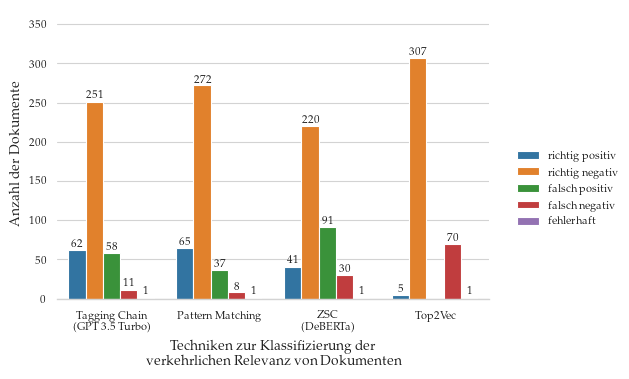

In [26]:
df_classify_melt = pd.melt(df_classify, id_vars='Kategorie')
df_classify_melt = df_classify_melt[df_classify_melt['value'] > 0]
width='thesis'

hue_order_classify = ['richtig positiv','richtig negativ',
            'falsch positiv','falsch negativ', 'fehlerhaft']
g = sns.catplot(
    data=df_classify_melt, kind="bar",
    x="variable", y="value", hue="Kategorie", hue_order=hue_order_classify,
    # errorbar="sd", palette="dark", alpha=.6, height=6
)
g.fig.set_size_inches(set_size(width))

# sns.set_style('whitegrid')
plt.style.use('tex.mplstyle')
g.set(xlabel='Techniken zur Klassifizierung der\nverkehrlichen Relevanz von Dokumenten', ylabel='Anzahl der Dokumente')
g.set_xticklabels(['Tagging Chain\n(GPT 3.5 Turbo)', 'Pattern Matching', 'ZSC\n(DeBERTa)', 'Top2Vec'])
g.despine(left=True)
g.legend.set_title(None)



for ax in g.axes.ravel():
    # add annotations
    for c in ax.containers:
        # add custom labels with the labels=labels parameter if needed
        # labels = [f'{h}' if (h := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, label_type='edge', fontsize=8)
    ax.margins(y=0.2)

g.tight_layout()

g.savefig('../../latex/Figures/plots/vergleich_classification.pdf', format='pdf', bbox_inches='tight')

In [125]:
df_ergebnisse

,Kategorie,TC,PM,ZSC,TC_doc_typ,doc_typ,TC_beratungsergebnis,TC_TOPIC,Top2Vec,TC_fraktion
0,richtig positiv,61,64,41,291,290,145,27,6,89
1,richtig negativ,251,272,220,7,14,191,343,348,242
2,richtig andere Angabe,0,1,0,1,0,9,3,1,43
3,falsch positiv,59,37,92,13,77,26,2,1,4
4,falsch negativ,11,8,29,70,2,12,8,27,5
5,nicht auslesbar,0,0,0,1,0,0,0,0,0
6,fehlerhaft,1,1,1,1,1,1,1,1,1


In [28]:
df_doc_typ = df_ergebnisse[['Kategorie', 'TC_doc_typ', 'doc_typ']]

In [30]:
set_size(width)

(6.299212813062128, 3.893127620841233)

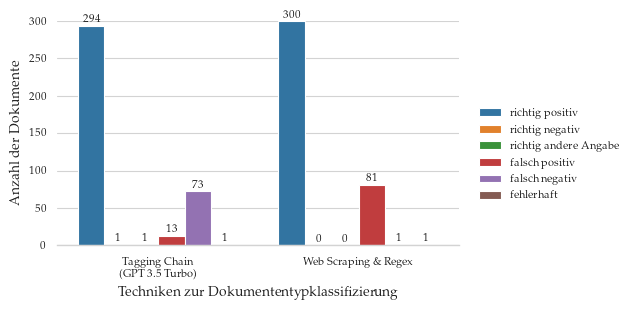

In [36]:
df_doc_typ_melt = pd.melt(df_doc_typ, id_vars='Kategorie')

hue_order_doc_typ = ['richtig positiv','richtig negativ', 'richtig andere Angabe',
            'falsch positiv','falsch negativ', 'fehlerhaft']
g = sns.catplot(
    data=df_doc_typ_melt, kind="bar",
    x="variable", y="value", hue="Kategorie", hue_order=hue_order_doc_typ,
    # errorbar="sd", palette="dark", alpha=.6, height=6
)
g.fig.set_size_inches((6.299212813062128, 3.2))

sns.set_style('whitegrid')
plt.style.use('tex.mplstyle')
g.set(xlabel='Techniken zur Dokumententypklassifizierung', ylabel='Anzahl der Dokumente')
g.set_xticklabels(['Tagging Chain\n(GPT 3.5 Turbo)', 'Web Scraping \& Regex'])
g.despine(left=True)
g.legend.set_title(None)
g.set(ylim=(0, 300))

for ax in g.axes.ravel():
    # add annotations
    for c in ax.containers:
        # add custom labels with the labels=labels parameter if needed
        # labels = [f'{h}' if (h := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, label_type='edge', fontsize=8)
    ax.margins(y=0.2)

g.tight_layout()

g.savefig('../../latex/Figures/plots/vergleich_doc_typ.pdf', format='pdf', bbox_inches='tight')

In [136]:
df_tc = df_ergebnisse[['Kategorie', 'TC_beratungsergebnis', 'TC_fraktion']]

In [37]:
df_tc_melt = pd.melt(df_tc, id_vars='Kategorie')

hue_order_doc_typ = ['richtig positiv','richtig negativ', 'richtig andere Angabe',
            'falsch positiv','falsch negativ', 'fehlerhaft']
g = sns.catplot(
    data=df_tc_melt, kind="bar",
    x="variable", y="value", hue="Kategorie", hue_order=hue_order_doc_typ,
    # errorbar="sd", palette="dark", alpha=.6, height=6
)
g.fig.set_size_inches((6.299212813062128, 3.2))

sns.set_style('whitegrid')
plt.style.use('tex.mplstyle')
g.set(xlabel='Datenextraktion mit Tagging Chain (GPT 3.5 Turbo)', ylabel='Anzahl der Dokumente')
g.set_xticklabels(['Beratungsergebnis', 'initiierende Fraktion'])
g.despine(left=True)
g.legend.set_title(None)

for ax in g.axes.ravel():
    # add annotations
    for c in ax.containers:
        # add custom labels with the labels=labels parameter if needed
        # labels = [f'{h}' if (h := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, label_type='edge', fontsize=8)
    ax.margins(y=0.2)

g.tight_layout()

g.savefig('../../latex/Figures/plots/vergleich_tc.pdf', format='pdf', bbox_inches='tight')

NameError: name 'df_tc' is not defined